In [1]:
import pandas as pd
df = pd.read_excel('Presentation - omics challenge Data.xlsx', index_col=0, header=1)
target = df['Label']
df = df.drop(['Label'], axis=1)
df_amino = df.iloc[:,0:21]
df_prot = df.iloc[:,21:]

C:\Users\Sudeep\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Scaling using MinMaxScaler

In [2]:
# Scaling using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df_amino_scaled = pd.DataFrame(scaler.fit_transform(df_amino), columns=df_amino.columns, index=df.index)
df_prot_scaled = pd.DataFrame(scaler.fit_transform(df_prot), columns = df_prot.columns, index=df.index)

In [ ]:
(df == 0).astype(int).sum(axis=0) #checking count of zeros across samples for each feature
#(df == 0).astype(int).sum(axis=0).to_csv('count.csv')


In [5]:
df_combined = pd.concat([df_amino_scaled,df_prot_scaled], axis=1)
#df_combined

### Train-test splitting

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_combined, target, stratify=target, random_state=42)

### Classification using Random Forest and grid search to tune hyper-parameters

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [2,4,8,16],
    'min_samples_leaf': [2, 3],
    'n_estimators': [4, 8]
}
#Create a based model
rf = RandomForestClassifier()

grid = GridSearchCV(rf,param_grid=param_grid,cv=4,scoring='accuracy')
model_grid = grid.fit(X_train,y_train)

print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 3, 'n_estimators': 8}
Best score is: 0.8875


In [8]:
from sklearn.metrics import accuracy_score, classification_report

rf_optimized = model_grid.best_estimator_
y_pred = rf_optimized.predict(X_test)
print('Accuracy: {:0.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 0.83
              precision    recall  f1-score   support

         CRC       1.00      0.67      0.80         3
     Control       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



### Feature Selection

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
forest_importances = pd.Series(rf_optimized.feature_importances_, index=df_combined.columns)
sorted_features = forest_importances.sort_values(ascending=False)

C:\Users\Sudeep\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


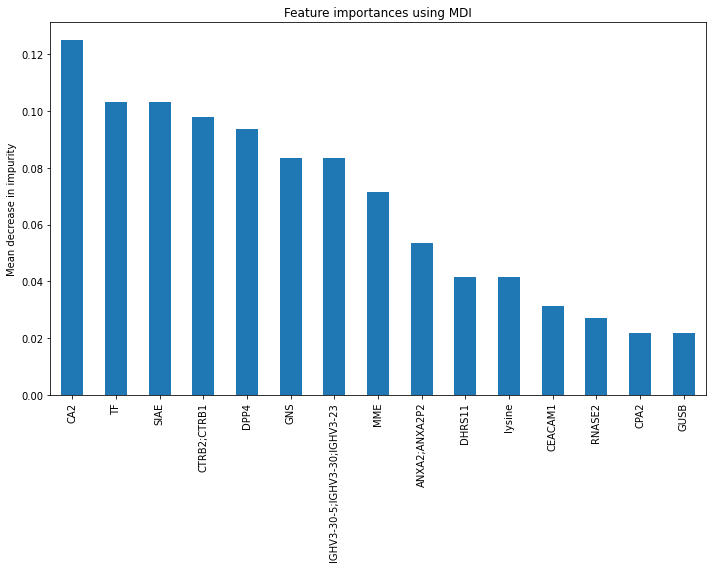

In [11]:
#Select number of features
n=15
fig, ax = plt.subplots(figsize=(10,8))
sorted_features[0:n].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### code for evaluating the model's accuracy and generating the classification report:

5-Fold Cross-Validation scores: [0.75 0.75 0.75 1.   1.  ]
Mean CV score: 0.85
Standard Deviation of CV scores: 0.1224744871391589


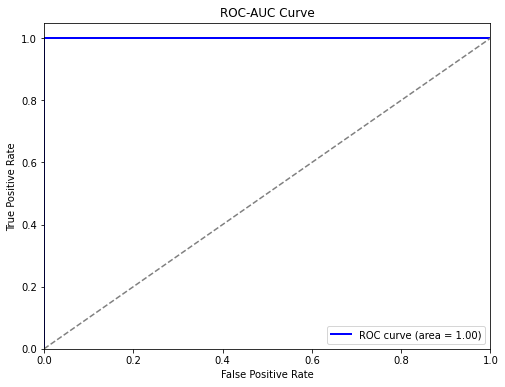

Best hyperparameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 2, 'n_estimators': 8}
Best score: 0.875
Accuracy: 0.67
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



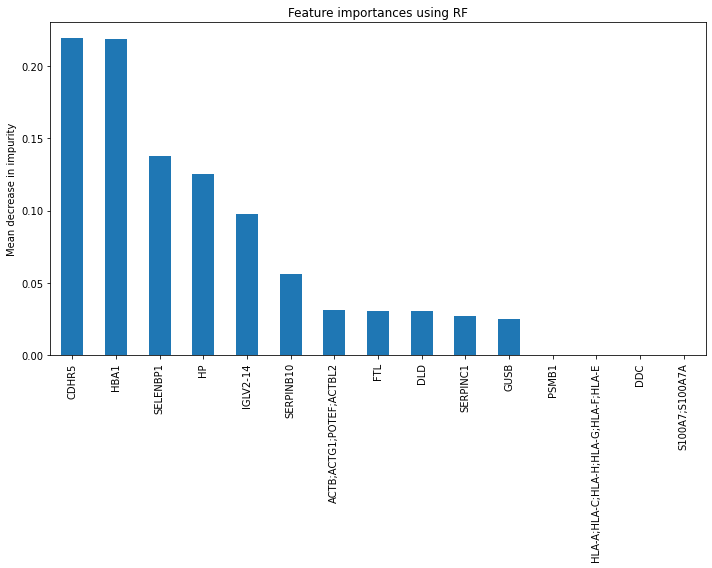

In [21]:
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the dataset and prepare data
df = pd.read_excel('Presentation - omics challenge Data.xlsx', index_col=0, header=1)
target = df['Label']
df = df.drop(['Label'], axis=1)
df_amino = df.iloc[:, 0:21]
df_prot = df.iloc[:, 21:]

# Scaling using MinMaxScaler
scaler = MinMaxScaler()
df_amino_scaled = pd.DataFrame(scaler.fit_transform(df_amino), columns=df_amino.columns, index=df.index)
df_prot_scaled = pd.DataFrame(scaler.fit_transform(df_prot), columns=df_prot.columns, index=df.index)

# Combine scaled data
df_combined = pd.concat([df_amino_scaled, df_prot_scaled], axis=1)

# Encode the labels to binary format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)  # 'Control' becomes 0, 'CRC' becomes 1

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_combined, y_encoded, stratify=y_encoded, random_state=42)

# Define the Random Forest model and GridSearchCV parameters
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 4, 8, 16],
    'min_samples_leaf': [2, 3],
    'n_estimators': [4, 8]
}

rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid=param_grid, cv=4, scoring='accuracy')
model_grid = grid.fit(X_train, y_train)

# k-Fold Cross-Validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_grid.best_estimator_, X_train, y_train, cv=kf, scoring='accuracy')

print(f'{k}-Fold Cross-Validation scores:', cv_scores)
print('Mean CV score:', cv_scores.mean())
print('Standard Deviation of CV scores:', cv_scores.std())

# ROC-AUC Curve (on the test set)
best_rf = model_grid.best_estimator_
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

print('Best hyperparameters:', model_grid.best_params_)
print('Best score:', model_grid.best_score_)

# Model evaluation on test set
rf_optimized = model_grid.best_estimator_
y_pred = rf_optimized.predict(X_test)

# Print accuracy and classification report
print('Accuracy: {:0.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

# Feature importances
forest_importances = pd.Series(rf_optimized.feature_importances_, index=df_combined.columns)
sorted_features = forest_importances.sort_values(ascending=False)

# Select number of features
n = 15
fig, ax = plt.subplots(figsize=(10, 8))
sorted_features[0:n].plot.bar(ax=ax)
ax.set_title("Feature importances using RF")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


### whole code 

5-Fold Cross-Validation scores: [0.5        1.         0.25       0.66666667 0.66666667]
Mean CV score: 0.6166666666666666
Standard Deviation of CV scores: 0.24494897427831783


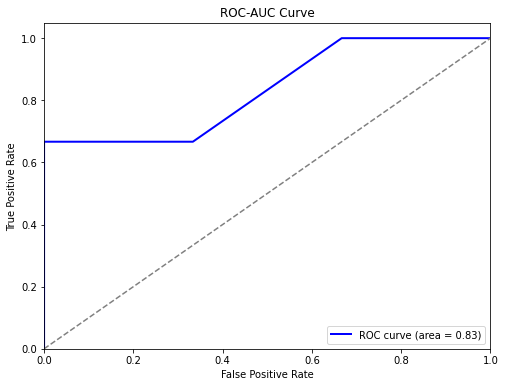

Best hyperparameters: {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 4}
Best score: 0.7875
Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



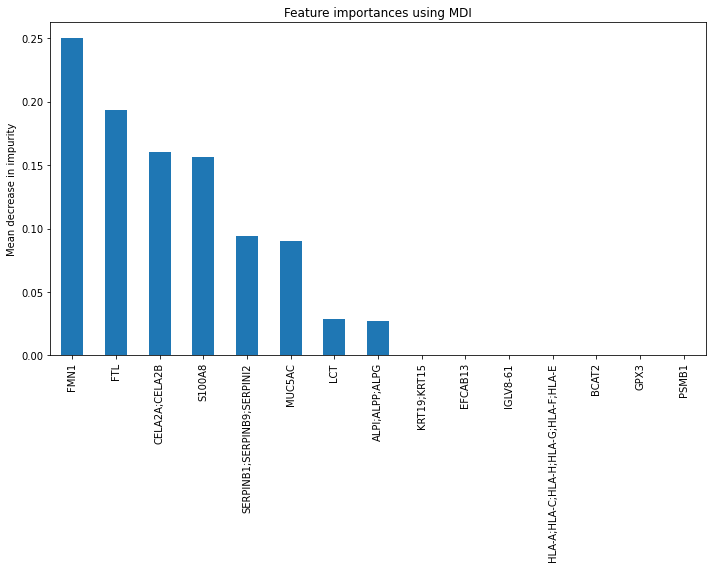

perform_differential_expression: results_amino 
             Feature  Statistic   p_value  log2_fold_change
0   sulfo-l-cystine   0.927025  0.363973         -0.215729
1     Aspartic acid   0.745417  0.463910         -0.160695
2         threonine   0.920978  0.367051         -0.213909
3            serine   0.565555  0.577419         -0.137854
4     glutamic acid   1.336444  0.195063         -0.343748
5         glutamine  -0.586600  0.563444          0.147640
6           proline   1.603000  0.123196         -1.033803
7           glycine   1.545257  0.136549         -0.575397
8           alanine   1.328863  0.197512         -0.482443
9        citrulline   0.271567  0.788487         -0.065416
10           valine   1.162594  0.257451         -0.440265
11       methionine   0.528563  0.602401         -0.174188
12       isoleucine   0.515768  0.611161         -0.177327
13          leucine   1.376663  0.182467         -0.456570
14         tyrosine   0.918989  0.368068         -0.304813
15    p

C:\Users\Sudeep\AppData\Local\Temp/ipykernel_8788/2812831153.py:106: RuntimeWarning: divide by zero encountered in log2
  fold_change = np.log2(df[column][labels == 1].mean() / df[column][labels == 0].mean())
C:\Users\Sudeep\AppData\Local\Temp/ipykernel_8788/2812831153.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  fold_change = np.log2(df[column][labels == 1].mean() / df[column][labels == 0].mean())
C:\Users\Sudeep\AppData\Local\Temp/ipykernel_8788/2812831153.py:106: RuntimeWarning: invalid value encountered in scalar divide
  fold_change = np.log2(df[column][labels == 1].mean() / df[column][labels == 0].mean())


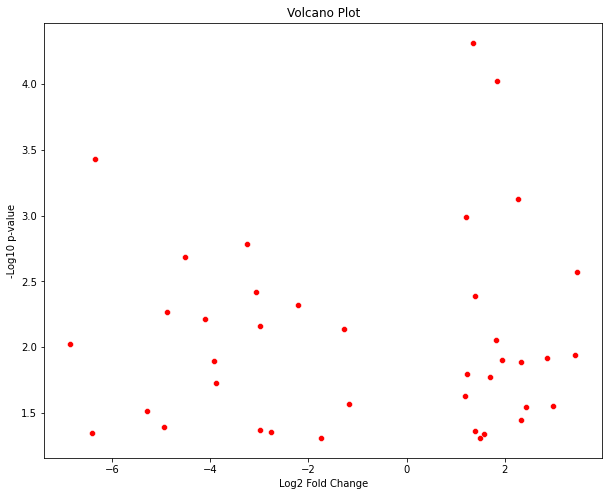

In [30]:
import pandas as pd
import scipy.stats as stats
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset and prepare data
df = pd.read_excel('Presentation - omics challenge Data.xlsx', index_col=0, header=1)
target = df['Label']
df = df.drop(['Label'], axis=1)
df_amino = df.iloc[:, 0:21]
df_prot = df.iloc[:, 21:]

# Scaling using MinMaxScaler
scaler = MinMaxScaler()
df_amino_scaled = pd.DataFrame(scaler.fit_transform(df_amino), columns=df_amino.columns, index=df.index)
df_prot_scaled = pd.DataFrame(scaler.fit_transform(df_prot), columns=df_prot.columns, index=df.index)

# Combine scaled data
df_combined = pd.concat([df_amino_scaled, df_prot_scaled], axis=1)

# Encode the labels to binary format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)  # 'Control' becomes 0, 'CRC' becomes 1

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_combined, y_encoded, stratify=y_encoded, random_state=42)

# Define the Random Forest model and GridSearchCV parameters
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 4, 8, 16],
    'min_samples_leaf': [2, 3],
    'n_estimators': [4, 8]
}

rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid=param_grid, cv=4, scoring='accuracy')
model_grid = grid.fit(X_train, y_train)

# k-Fold Cross-Validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_grid.best_estimator_, X_train, y_train, cv=kf, scoring='accuracy')

print(f'{k}-Fold Cross-Validation scores:', cv_scores)
print('Mean CV score:', cv_scores.mean())
print('Standard Deviation of CV scores:', cv_scores.std())

# ROC-AUC Curve (on the test set)
best_rf = model_grid.best_estimator_
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

print('Best hyperparameters:', model_grid.best_params_)
print('Best score:', model_grid.best_score_)

# Model evaluation on test set
rf_optimized = model_grid.best_estimator_
y_pred = rf_optimized.predict(X_test)

# Print accuracy and classification report
print('Accuracy: {:0.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

# Feature importances
forest_importances = pd.Series(rf_optimized.feature_importances_, index=df_combined.columns)
sorted_features = forest_importances.sort_values(ascending=False)

# Select number of features
n = 15
fig, ax = plt.subplots(figsize=(10, 8))
sorted_features[0:n].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

### Differential Expression Analysis

# Function for performing the t-test or Mann-Whitney U test
def perform_differential_expression(df, labels, test='t-test'):
    results = []
    for column in df.columns:
        if test == 't-test':
            stat, p_value = stats.ttest_ind(df[column][labels == 0], df[column][labels == 1])
        elif test == 'mannwhitney':
            stat, p_value = stats.mannwhitneyu(df[column][labels == 0], df[column][labels == 1])
        
        fold_change = np.log2(df[column][labels == 1].mean() / df[column][labels == 0].mean())
        results.append((column, stat, p_value, fold_change))
    
    results_df = pd.DataFrame(results, columns=['Feature', 'Statistic', 'p_value', 'log2_fold_change'])
    return results_df

# Perform the differential expression analysis
results_amino = perform_differential_expression(df_amino, y_encoded, test='t-test')
print('perform_differential_expression: results_amino \n', results_amino)
results_prot = perform_differential_expression(df_prot, y_encoded, test='t-test')

# Combine results
results_combined = pd.concat([results_amino, results_prot])

# Filter out NaN or zero p-values to avoid issues with log10
results_combined = results_combined.dropna(subset=['p_value'])
results_combined = results_combined[results_combined['p_value'] > 0]

# Volcano Plot
plt.figure(figsize=(10, 8))
# sns.scatterplot(x='log2_fold_change', y=-np.log10(results_combined['p_value']), data=results_combined)
plt.title('Volcano Plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 p-value')

# Highlight significant points (e.g., p-value < 0.05 and abs(log2_fold_change) > 1)
significant = results_combined[(results_combined['p_value'] < 0.05) & (abs(results_combined['log2_fold_change']) > 1)]
sns.scatterplot(x='log2_fold_change', y=-np.log10(significant['p_value']), data=significant, color='red')
plt.show()
